# Getting the Model

First we install the requirements as mentioned in the README.md file.

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


Import all the dependencies needed for the predict function.

In [2]:
import pandas as pd
import joblib
from pydantic import BaseModel, Field
from pydantic.tools import parse_obj_as

These are the Pydantic models for data validation and modeling that are used within the model. They are not used in this notebook, but are here to provide further insight into how to model is working.

In [3]:
# Pydantic Models
class Student(BaseModel):
    student_id: str = Field(alias="Student ID")
    gender: str = Field(alias="Gender")
    age: str = Field(alias="Age")
    major: str = Field(alias="Major")
    gpa: str = Field(alias="GPA")
    extra_curricular: str = Field(alias="Extra Curricular")
    num_programming_languages: str = Field(alias="Num Programming Languages")
    num_past_internships: str = Field(alias="Num Past Internships")

    class Config:
        allow_population_by_field_name = True

class PredictionResult(BaseModel):
    good_employee: int

This is the predict function. It is the function that is provided in the model that we are evaluating in this notebook.

In [4]:
# Main Functionality
def predict(student):
    '''
    Returns a prediction on whether the student will be a good employee
    based on given parameters by using the ML model

    Parameters
    ----------
    student : dict
        A dictionary that contains all fields in Student
    
    Returns
    -------
    dict
        A dictionary satisfying type PredictionResult, contains a single field
        'good_employee' which is either 1 (will be a good employee) or 0 (will
        not be a good employee)
    '''
    # Use Pydantic to validate model fields exist
    student = parse_obj_as(Student, student)

    clf = joblib.load('./model.pkl')
    
    student = student.dict(by_alias=True)
    query = pd.DataFrame(student, index=[0])
    prediction = clf.predict(query) # TODO: Error handling ??

    return { 'good_employee': prediction[0] }

All the code above was provided in the draft pull request. Now we will use the sample from the README.md file to make sure it works as intended.

In [5]:
student = {
        "student_id": "student1",
        "major": "Computer Science",
        "age": "20",
        "gender": "M",
        "gpa": "4.0",
        "extra_curricular": "Men's Basketball",
        "num_programming_languages": "1",
        "num_past_internships": "2"
    }

In [6]:
predict(student)

{'good_employee': 1}

It works :) Now we can start evaluating the model.

# Evaluating Model Performance & Fairness

Since we don't know how the model provided in the draft pull request was trained, we want to evaluate it before implementing it into NodeBB. In the rest of the notebook, we will be evaluating the model's performance and fairness.

The engineer who created the model made the following assumptions:
- The model is used to predict whether a student will be a good candidate for a software engineering job.
- It is a binary classifier, where 1 means the student is a good candidate, and 0 means the student is not a good candidate.
- The model is trained on a dataset of students who have graduated from CMU, and have been working in the industry for at least 1 year.
- In order to prevent bias, they assumed that removing Gender (M, F) and Student ID from the dataset would be sufficient when it comes to training the model. They claimed that it is now Group Unaware, thus the model would be fair.

The model specification is as follows:

In [7]:
# X variable (input parameters)
# - Age (18 - 25)
# - Major (Computer Science, Information Systems, Business, Math,
#          Electrical and Computer Engineering, Statistics and Machine Learning)
# - GPA (0 - 4.0)
# - Extra Curricular Activities (Student Theatre, Buggy, Teaching Assistant, Student Government,
#     Society of Women Engineers, Women in CS, Volleyball, Sorority, Men's Basketball,
#     American Football, Men's Golf, Fraternity)
# - Number of Programming Languages (1, 2, 3, 4, 5)
# - Number of Past Internships (0, 1, 2, 3, 4)

# Y variable (output)
# - Good Candidate (0, 1)

A test dataset has been provided to us in the following format:

In [8]:
# X variable
# - Student ID
# - Gender (M, F)
# - Age (18 - 25)
# - Major (Computer Science, Information Systems, Business, Math,
#          Electrical and Computer Engineering, Statistics and Machine Learning)
# - GPA (0 - 4.0)
# - Extra Curricular Activities (Student Theatre, Buggy, Teaching Assistant, Student Government,
#     Society of Women Engineers, Women in CS, Volleyball, Sorority, Men's Basketball,
#     American Football, Men's Golf, Fraternity)
#   # Likely Co-Ed (Student Theatre, Buggy, Teaching Assistant, Student Government)
#   # Likely Majority Female (Society of Women Engineers, Women in CS, Volleyball, Sorority)
#   # Likely Majority Male (Men's Basketball, American Football, Men's Golf, Fraternity)
# - Number of Programming Languages (1, 2, 3, 4, 5)
# - Number of Past Internships (0, 1, 2, 3, 4)

# Y variable
# - Good Candidate (0, 1)

This test dataset is a different set of students from the training dataset, and the evaluation of whether the student is a good candidate is done by a fair panel of recruiters, so it can be considered to be unbiased. Additionally, the panel of recruiters have provided us with additional context on the extracurricular activities in comments (marked with #).

## Preliminary Analysis

Before we evaluate the fairness of the model, we want to do a prelimiary analysis on the test dataset.

In [9]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Matplotlib is building the font cache; this may take a moment.


### Loading the Model and Test Dataset

The first thing we have to do is load the model and test dataset.

In [10]:
test_df = pd.read_csv("student_data.csv")
model = pickle.load(open("model.pkl","rb"))

### Plotting the Distributions of the Test Dataset

Now we want to plot the distribution of the test dataset across all features (except Student ID). We will be using the seaborn library.

In [11]:
test_df.head()

,Student ID,Gender,Age,Major,GPA,Extra Curricular,Num Programming Languages,Num Past Internships,Good Candidate
0,0,F,21,Statistics and Machine Learning,2.83,Sorority,4,1,0
1,1,M,20,Information Systems,2.89,Fraternity,5,3,0
2,2,F,20,Math,2.66,Teaching Assistant,3,1,0
3,3,M,20,Information Systems,2.48,Fraternity,5,0,0
4,4,F,21,Statistics and Machine Learning,3.30,Sorority,2,1,0


In [12]:
test_df.describe()

,Student ID,Age,GPA,Num Programming Languages,Num Past Internships,Good Candidate
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000
mean,249.500000,20.944000,2.905780,3.04600,2.052000,0.474000
std,144.481833,1.455025,0.839559,1.36073,1.407572,0.499824
min,0.000000,18.000000,0.000000,1.00000,0.000000,0.000000
25%,124.750000,20.000000,2.345000,2.00000,1.000000,0.000000
50%,249.500000,21.000000,2.990000,3.00000,2.000000,0.000000
75%,374.250000,22.000000,3.560000,4.00000,3.000000,1.000000
max,499.000000,25.000000,4.000000,5.00000,4.000000,1.000000


Gender (Categorical - M/F)
- Bar chart: Show the count of each gender category using bars.

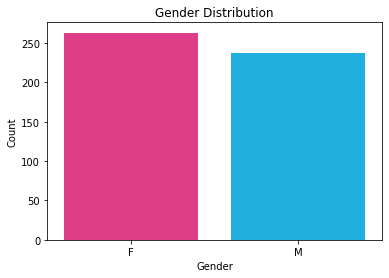

In [13]:
# Group the data by gender and count the occurrences
gender_counts = test_df["Gender"].value_counts()

# Define a custom color ramp palette using Matplotlib's LinearSegmentedColormap
colors = ["#F72585", "#C6009F", "#7209B7", "#3A0CA3", "#4361EE", "deepskyblue"]
n_colors = len(colors)
color_ramp = np.linspace(0, 1, n_colors)
colormap = plt.matplotlib.colors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(color_ramp, colors)))

# Create the custom colormap
num_colors = 2
color_list = [colormap(i / (num_colors - 1)) for i in range(num_colors)]

# Create a bar chart
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette=color_list, hue=gender_counts.index, legend=False)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

The gender distribution seems pretty fair and even, but we know it's not used in the model according to the draft pull request so we don't need to worry about it.

Age (Numerical - Integer)
- Histogram: Visualize the distribution of ages using a histogram.

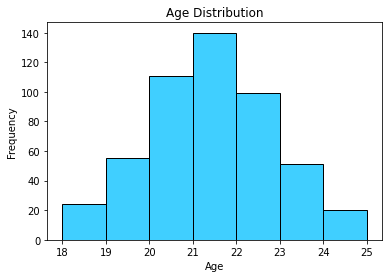

In [14]:
# Create a histogram using Seaborn
sns.histplot(test_df["Age"], bins=7, color="deepskyblue")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution")
plt.show()

Unfortunately, we do not have a very even representation of ages at all. While we could assume most students fall between 20-23, there isn't really enough test data on this to show how well the model uses ages as a feature.

Major (Categorical - String)
- Bar chart: Show the count of each major category.

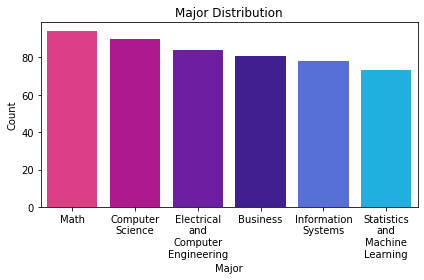

In [15]:
# Count the occurrences of each major category
major_counts = test_df["Major"].value_counts()

# Modify labels to wrap after every space
wrapped_labels = [label.replace(" ", "\n") for label in major_counts.index]

# Create the custom colormap
num_colors = 6
color_list = [colormap(i / (num_colors - 1)) for i in range(num_colors)]

# Create a barplot using Seaborn with modified labels
sns.barplot(x=wrapped_labels, y=major_counts.values, palette=color_list, hue=wrapped_labels, legend=False)

plt.title("Major Distribution")
plt.xlabel("Major")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

The major distribution is fairly even, which is good.

GPA (Numerical - Float)
- Histogram: Visualize the distribution of GPAs using a histogram.

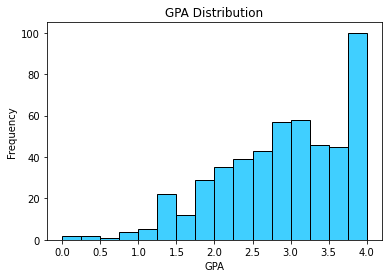

In [16]:
sns.histplot(test_df["GPA"], bins=16, color="deepskyblue")
plt.xlabel("GPA")
plt.ylabel("Frequency")
plt.title("GPA Distribution")
plt.show()

We do not have enough data in the test set for lower GPAs to know whether the model really uses the GPA feature well when predicting the output. Also, the overrepresentation of 3.5+ GPAs on the test set might indicate a similar problem could have occured while training the model.

Extra Curricular (Categorical - String)
- Bar chart: Show the count of each type of extracurricular activity.

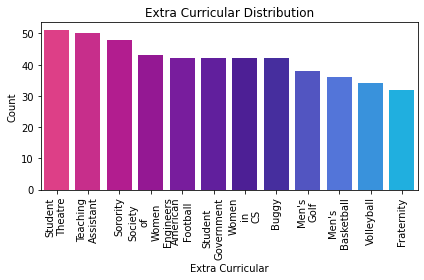

In [17]:
# Count the occurrences of each extra-curricular category
ec_counts = test_df["Extra Curricular"].value_counts()

# Create a barplot using Seaborn with the custom colormap
num_colors = 12
color_list = [colormap(i / (num_colors - 1)) for i in range(num_colors)]
sns.barplot(x=ec_counts.index, y=ec_counts.values, palette=color_list, hue=ec_counts.index, legend=False)

# Modify labels to wrap after every space
wrapped_labels = [label.replace(" ", "\n") for label in ec_counts.index]

# Set the modified labels as xticklabels
plt.xticks(range(len(wrapped_labels)), wrapped_labels)

plt.title("Extra Curricular Distribution")
plt.xlabel("Extra Curricular")
plt.ylabel("Count")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

Extra-curriculars seem quite evenly distributed, so this looks good.

Num Programming Languages (Numerical - Integer)
- Bar chart: Show the count of the number of programming languages.
- Could use a histogram, but the range is not that big.

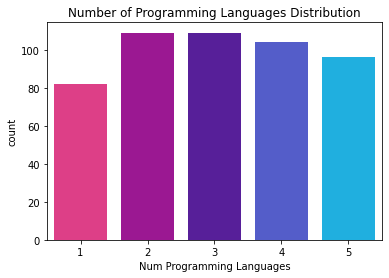

In [18]:
# Create the custom colormap
num_colors = 5
color_list = [colormap(i / (num_colors - 1)) for i in range(num_colors)]

# Create the barplot
sns.countplot(data=test_df, x="Num Programming Languages", palette=color_list, hue="Num Programming Languages", legend=False)
plt.title("Number of Programming Languages Distribution")
plt.show()

There seems to be a good distribution of programming languages as well.

Num Past Internships (Numerical - Integer)
- Bar chart: Show the count of the number of past internships.
- Could use a histogram, but the range is not that big.

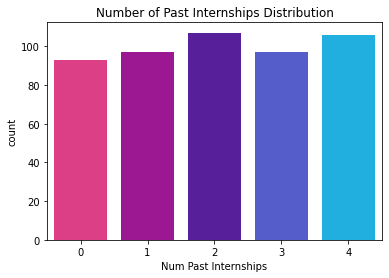

In [19]:
# Create the custom colormap
num_colors = 5
color_list = [colormap(i / (num_colors - 1)) for i in range(num_colors)]

# Create the barplot
sns.countplot(data=test_df, x="Num Past Internships", palette=color_list, hue="Num Past Internships", legend=False)
plt.title("Number of Past Internships Distribution")
plt.show()

We also find a good and even distribution for the number of past internships.

Good Candidate (Target - Binary)
- Bar chart: Show the distribution of candidates being classified as "good" (1) or not (0).

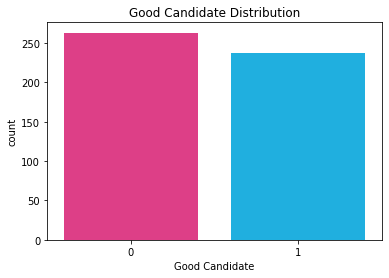

In [20]:
# Create the custom colormap
num_colors = 2
color_list = [colormap(i / (num_colors - 1)) for i in range(num_colors)]

sns.countplot(data=test_df, x="Good Candidate", palette=color_list, hue="Good Candidate", legend=False)
plt.title("Good Candidate Distribution")
plt.show()

The targets also seem to be balanced in the test set, which is good for using accuracy score as a metric.

## Running the Model

Now we will run the model on the test dataset to get the accuracy of the model.

First, we have to predict the output of the test dataset using the model.

In [21]:
# we split the data into our inputs and the label
test_df = test_df.drop(["Student ID", "Gender"], axis=1)
x_test = test_df.drop(["Good Candidate"], axis=1)
y_test = test_df["Good Candidate"]

In [22]:
# perform the predictions using the predict function built into the model, which we have also described at the beginning of the notebook.
y_pred = model.predict(x_test)

Now we can report the accuracy of the model along with the confusion matrix.

In [23]:
# now we can compute the accuracy of those predictions
print('Accuracy Score: ', accuracy_score(y_pred, y_test))

Accuracy Score:  0.832


An accuracy of 83.2% is a good result, but we would want to aim for something closer to 90-95%. Still, the provided model is not bad according to this.

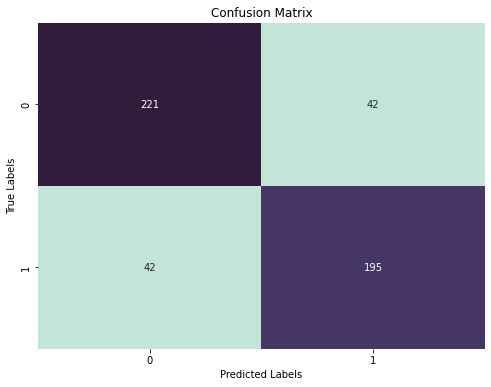

In [24]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

The confusion matrix further emphasizes that we want a more accurate model than the one the engineer provided to us, as 84 students being misrepresented in the career feature is quite a lot from a subjective standpoint.

In [25]:
# ⠀⢀⡤⢚⡭⣿⡟⠉⠉⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠁⠉⠁⠀⠀⠀⠉⠉⠁⠀⠉⣿⠀⠀⠀⠀⠀
# ⠀⠀⠀⢁⢶⡟⠀⠀⠀⠘⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠸⠀⠀⠀⠀⡆⠁⢀⠀⡇⠠⣼⡄⠀⠀⠀⠀
# ⠀⠀⢠⠏⣾⠁⡄⠀⠀⡃⠀⢡⠀⠀⠀⠃⠀⠀⠀⠀⠀⠀⠀⡁⠀⠀⢠⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⣇⠇⠀⢀⡄⢸⢀⡆⢸⡰⡆⢸⠿⣧⠀⠀⠀⠀
# ⠀⠀⡜⣰⡏⠀⠧⠂⠰⠇⢰⣸⡄⠀⣼⡀⠀⠄⢠⠀⡀⠀⢠⡇⠀⢀⢾⠀⠀⢀⠇⠀⠀⠀⠀⠀⠀⡀⣸⠀⢀⢸⡟⠀⠀⡼⠀⡇⣼⡁⠆⡇⣧⢸⠀⠈⠀⠀⠀⠀
# ⠀⢠⣷⠇⠀⢸⢸⠀⢰⠄⣸⡟⡇⢀⠽⡇⢀⡇⠘⠰⠁⠀⡞⡇⠀⡜⢸⡀⠀⣸⡄⠀⢀⠀⠀⢀⠴⢃⡇⢀⣇⠞⣓⠲⣴⠁⢸⢰⡇⢧⠀⣸⢿⣼⠀⠀⠀⠀⠀⠀
# ⠀⣼⡏⢀⡆⠘⢸⠀⢸⠀⣿⣤⡇⣸⠀⡇⢸⡆⠂⢸⠀⢰⠇⡇⢰⠗⢻⡃⢸⣿⠀⠀⢸⠀⢀⡏⠀⣋⠅⣼⠋⣼⣿⡇⣇⠀⣿⠏⣧⢸⢠⣿⠀⠻⠀⠀⠀⠀⠀⠀
# ⢠⣿⢀⡞⠀⡀⢸⢀⠸⣾⣿⣹⣇⡇⣄⡇⣼⡇⠀⣼⠀⡾⠉⢱⡞⠀⢀⡇⡞⢹⠀⠀⣾⠀⣼⡇⢠⣿⢠⠇⠘⣿⡇⢣⣸⡄⡞⠀⣿⠈⣿⡏⠀⠀⠀⠀⠀⠀⠀⠀
# ⢸⣿⢻⠇⣠⡇⣹⢸⡆⣿⠿⣿⣿⣄⢸⡇⡏⢿⡮⢹⢰⡇⣠⣼⡷⣶⣿⣿⣁⢘⠠⠇⣿⢰⣱⡁⣸⣿⡼⠀⣾⠿⠏⢸⢋⣿⣷⣤⠙⣇⣿⣇⠀⠀⠀⠀⠀⠀⠀⠀
# ⠾⠁⠘⡰⢋⣧⣇⣸⣷⡞⠓⠺⢧⣘⣆⢻⠇⢸⡇⣸⣞⣹⡿⠛⠻⣏⣀⡭⠙⢛⡶⠦⣟⢫⣿⡿⠉⣿⠇⠀⡿⠁⠀⢧⣞⣿⡇⢻⣧⡘⣿⣿⡆⠀⠀⠀⠀⠀⠀⠀
# ⠀⢠⡿⠁⢸⠇⣼⠋⡿⣧⡀⠀⠀⠙⣿⡿⠀⢹⣶⠟⠋⠛⠻⠶⣤⣀⠀⠠⠔⠋⣣⣾⡏⡞⢸⠃⠀⡿⠀⠀⠁⠀⡰⠋⠘⠾⡇⠀⠙⠳⣿⣿⣿⡀⠀⠀⠀⠀⠀⠀
# ⠀⡾⠁⢀⡏⢰⠃⠀⡇⢿⠿⣿⣿⣿⣿⠷⠶⠾⢿⣦⣀⣀⣀⣀⣈⣿⣇⢀⣴⠟⠉⢸⡿⠁⠊⠀⠀⠃⣀⣄⣠⠞⠁⠀⠀⠀⠀⠀⠀⣰⣿⣿⣿⣷⣦⣀⠀⠀⠀⠀
# ⠈⠁⠀⠼⠁⠁⠀⠀⠃⢸⠀⢹⡉⠛⠋⠀⠀⠀⠀⠻⢿⣿⣿⣿⣿⣿⣿⣛⡟⠀⠀⠛⠃⠀⠀⠀⠀⢠⡿⠏⣠⡆⠀⠀⠀⠀⠀⣠⣾⣿⣿⣿⣿⣿⣿⣿⣿⣦⡀⠀
# ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⢷⣤⡀⠀⠀⠀⠀⠀⠀⠈⠙⠛⠛⠋⠉⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⢾⠁⣰⣿⡇⠀⠀⠀⢀⣼⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣄
# ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣿⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢟⣹⠀⠀⠀⣠⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
# ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢾⣯⣄⣀⡀⠀⠀⠀⠀⣀⡤⠖⠋⠀⠀⠀⠀⠀⢀⣠⡤⠀⠀⠀⢺⣿⡀⢀⣼⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
# ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⢀⣩⡗⠒⠒⠉⠀⠀⠀⠀⠀⠀⠀⣠⣴⣿⠏⠀⠀⠀⠀⣾⠏⣰⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
# ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠧⠴⢿⡋⠁⠀⠀⠀⠀⠀⠀⠀⠀⣠⣞⢻⠟⠁⠀⠀⠀⠀⠀⣡⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
# ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢳⣄⡀⠀⠀⠀⠀⣀⣴⣮⣹⡿⠃⠀⠀⠀⠀⣀⣴⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿